## Method
- Normalize prediction risk maps (0, 1)
- Get max and average prediction risk map based on risk matrix obtained from different DB (experiment_10_2_SEPPexp...)
- Compute entropy for prediction by DB and multimodal (by operator)
- Measure hit rate and PAI for specific coverage (10%) considering different ground truth scenarios: SIEDCO, RNMC, NUSE. Visualize hit rate and entropy to analyze posible relations.

## Hypothesis:
The entropy is higher for risk prediction maps associated with the DB with the largest amount of data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

### Fusion operators

In [5]:
def average_grid_prediction(row):
    xoffset_avg = (row['prediction_siedco']._xoffset + row['prediction_rnmc']._xoffset + row['prediction_nuse']._xoffset)/3
    yoffset_avg = (row['prediction_siedco']._yoffset + row['prediction_rnmc']._yoffset + row['prediction_nuse']._yoffset)/3
    xsize_avg = (row['prediction_siedco']._xsize + row['prediction_rnmc']._xsize + row['prediction_nuse']._xsize)/3
    ysize_avg = (row['prediction_siedco']._ysize + row['prediction_rnmc']._ysize + row['prediction_nuse']._ysize)/3
    matrix_avg = (row['prediction_siedco']._matrix + row['prediction_rnmc']._matrix + row['prediction_nuse']._matrix)/3
    return open_cp.predictors.GridPredictionArray(xsize=xsize_avg,ysize=ysize_avg,matrix=matrix_avg,xoffset=xoffset_avg,yoffset=yoffset_avg)

In [6]:
import operator

def maximum_grid_prediction(row):
    max_intensity = {}
    max_intensity['siedco']=np.sum(row['prediction_siedco']._matrix)
    max_intensity['rnmc']=np.sum(row['prediction_rnmc']._matrix)
    max_intensity['nuse']=np.sum(row['prediction_nuse']._matrix)
    key_max_intensity = max(max_intensity.items(), key=operator.itemgetter(1))[0]
    
    column = 'prediction_'+str(key_max_intensity)
    xoffset_max = row[column]._xoffset
    yoffset_max = row[column]._yoffset
    xsize_max = row[column]._xsize
    ysize_max = row[column]._ysize
    matrix_max = row[column]._matrix
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_max,xoffset=xoffset_max,yoffset=yoffset_max)


### Descriptive metrics

In [7]:
def shannon_entropy(matrix):
    my_array = np.squeeze(np.asarray(matrix))
    # ignore zero values for successful compute of log in entropy eq.
    # https://stats.stackexchange.com/questions/57069/alternative-to-shannons-entropy-when-probability-equal-to-zero
    non_zero_array = my_array[my_array != 0]
    p_normalized = non_zero_array / non_zero_array.sum()
    entropy = -np.sum(p_normalized*np.log2(p_normalized))
    return entropy

In [8]:
from scipy.stats import entropy
import math

def scipy_entropy(matrix, base):
    my_array = np.squeeze(np.asarray(matrix))
    non_zero_array = my_array[my_array != 0]
    return entropy(pk=non_zero_array, base=base)

## Load prediction results

In [9]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [10]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [11]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [12]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_rnmc['prediction_normalized'] = loaded_rnmc.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_nuse['prediction_normalized'] = loaded_nuse.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)


In [13]:
# Delete not-normalized prediction columns
loaded_siedco.drop(columns=['prediction'], inplace=True)
loaded_rnmc.drop(columns=['prediction'], inplace=True)
loaded_nuse.drop(columns=['prediction'], inplace=True)

### Rename columns to merge df

In [14]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco','initial-date':'initial-date-siedco','final-date':'final-date-siedco'})
loaded_rnmc = loaded_rnmc.rename(columns={'prediction_normalized': 'prediction_rnmc', 'eval_pts': 'eval_pts_rnmc', 'initial-date':'initial-date-rnmc','final-date':'final-date-rnmc'})
loaded_nuse = loaded_nuse.rename(columns={'prediction_normalized': 'prediction_nuse', 'eval_pts': 'eval_pts_nuse', 'initial-date':'initial-date-nuse','final-date':'final-date-nuse'})

## Compute maximum and average prediction

In [15]:
result = pd.concat([loaded_siedco, loaded_rnmc, loaded_nuse], axis=1)

In [16]:
result['average_prediction'] = result.apply(lambda row: average_grid_prediction(row), axis=1)

In [17]:
result['max_prediction'] = result.apply(lambda row: maximum_grid_prediction(row), axis=1)

### Delete redundant columns

In [18]:
result.drop(columns=['initial-date-rnmc','final-date-rnmc','initial-date-nuse','final-date-nuse'], inplace=True)

In [19]:
result = result.rename(columns={'initial-date-siedco':'initial-date','final-date-siedco':'final-date'})

## Compute entropy

In [20]:
result['siedco_entropy'] = result.apply(lambda row: shannon_entropy(row['prediction_siedco']._matrix), axis=1)
result['rnmc_entropy'] = result.apply(lambda row: shannon_entropy(row['prediction_rnmc']._matrix), axis=1)
result['nuse_entropy'] = result.apply(lambda row: shannon_entropy(row['prediction_nuse']._matrix), axis=1)
result['multimodal_average_entropy'] = result.apply(lambda row: shannon_entropy(row['average_prediction']._matrix), axis=1)
result['multimodal_max_entropy'] = result.apply(lambda row: shannon_entropy(row['max_prediction']._matrix), axis=1)


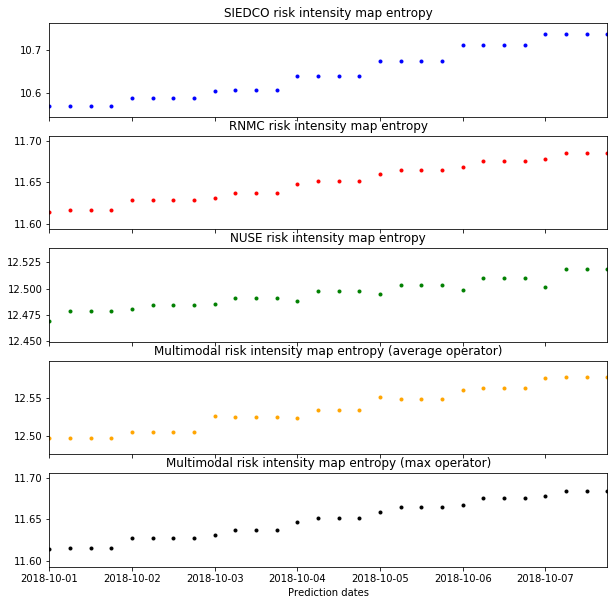

In [22]:
fig, ax = plt.subplots(5,1, figsize=(10,10), sharex=True)
siedco = ax[0].scatter(result['initial-date'].values,result['siedco_entropy'].values, marker=".",color='blue')
rnmc = ax[1].scatter(result['initial-date'].values,result['rnmc_entropy'].values, marker=".",color='red')
nuse = ax[2].scatter(result['initial-date'].values,result['nuse_entropy'].values, marker=".",color='green')
multimodal_average = ax[3].scatter(result['initial-date'].values,result['multimodal_average_entropy'].values, marker=".",color='orange')
multimodal_max = ax[4].scatter(result['initial-date'].values,result['multimodal_max_entropy'].values, marker=".",color='black')
ax[0].set_xlim(result['initial-date'].values[0],result['initial-date'].values[-1])
ax[0].set_title('SIEDCO risk intensity map entropy')
ax[1].set_title('RNMC risk intensity map entropy')
ax[2].set_title('NUSE risk intensity map entropy')
ax[3].set_title('Multimodal risk intensity map entropy (average operator)')
ax[4].set_title('Multimodal risk intensity map entropy (max operator)')
plt.xlabel('Prediction dates')
plt.show()

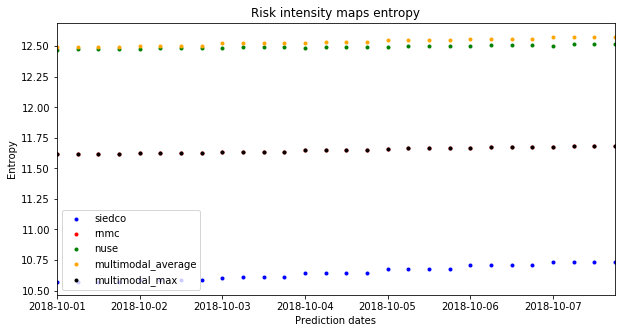

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.scatter(result['initial-date'].values,result['siedco_entropy'].values, marker=".",color='blue')
rnmc = ax.scatter(result['initial-date'].values,result['rnmc_entropy'].values, marker=".",color='red')
nuse = ax.scatter(result['initial-date'].values,result['nuse_entropy'].values, marker=".",color='green')
multimodal_average = ax.scatter(result['initial-date'].values,result['multimodal_average_entropy'].values, marker=".",color='orange')
multimodal_max = ax.scatter(result['initial-date'].values,result['multimodal_max_entropy'].values, marker=".",color='black')
ax.set_xlim(result['initial-date'].values[0],result['initial-date'].values[-1])
ax.set_title('Risk intensity maps entropy')
ax.legend((siedco, rnmc, nuse, multimodal_average, multimodal_max),('siedco', 'rnmc', 'nuse', 'multimodal_average', 'multimodal_max'))
plt.xlabel('Prediction dates')
plt.ylabel('Entropy')
plt.show()

## Hit rate and PAI

#### Real percentage of city coverage over rectangular region (based on script experiment_11_1_get_rectangular_city_region):

In [24]:
city_percentage_on_region = 0.26

In [25]:
## coverages are represented in % (NOT IN PROPORTION)
coverages = [2,4,6,8,10,12,14,16,18,20]
### this approach is only used to open_cp hit rate implementation method makes sense
real_coverages_city = list(map(lambda c: round((c/100)*city_percentage_on_region*100, 1), coverages))

In [26]:
## coverages are represented in % (NOT IN PROPORTION)
real_coverages_city

[0.5, 1.0, 1.6, 2.1, 2.6, 3.1, 3.6, 4.2, 4.7, 5.2]

### SIEDCO ground truth

In [27]:
df_result = result.copy()

In [28]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_siedco'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_siedco'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [29]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [30]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [31]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

siedco_entropy                   10.647107
rnmc_entropy                     11.649933
nuse_entropy                     12.495310
multimodal_average_entropy       12.535316
multimodal_max_entropy           11.649933
coverage_TP                       0.020564
hit_rate_TP                       0.023541
PAI_TP                          147.308426
hit_rate_default_coverage_2       0.265663
PAI_default_coverage_2           13.283166
hit_rate_default_coverage_4       0.422466
PAI_default_coverage_4           10.561642
hit_rate_default_coverage_6       0.548128
PAI_default_coverage_6            9.135473
hit_rate_default_coverage_8       0.651307
PAI_default_coverage_8            8.141343
hit_rate_default_coverage_10      0.726994
PAI_default_coverage_10           7.269942
hit_rate_default_coverage_12      0.803924
PAI_default_coverage_12           6.699370
hit_rate_default_coverage_14      0.851634
PAI_default_coverage_14           6.083101
hit_rate_default_coverage_16      0.874887
PAI_default

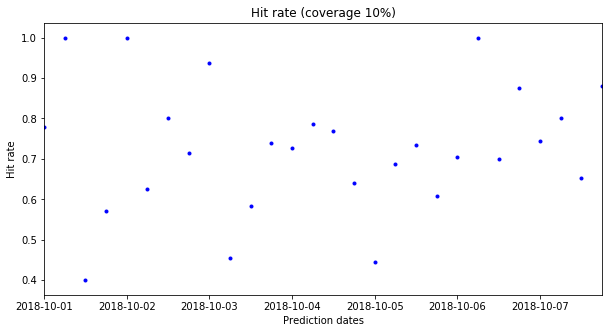

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['hit_rate_default_coverage_10'].values, marker=".",color='blue')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('Hit rate (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('Hit rate')
plt.show()

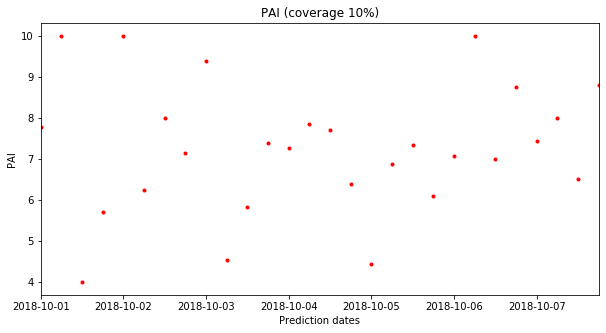

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['PAI_default_coverage_10'].values, marker=".",color='red')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('PAI (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('PAI')
plt.show()

### RNMC ground truth

In [34]:
df_result = result.copy()

In [35]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_rnmc'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_rnmc'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [36]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [37]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [38]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

siedco_entropy                  10.647107
rnmc_entropy                    11.649933
nuse_entropy                    12.495310
multimodal_average_entropy      12.535316
multimodal_max_entropy          11.649933
coverage_TP                      0.124019
hit_rate_TP                      0.107693
PAI_TP                          88.318215
hit_rate_default_coverage_2      0.433587
PAI_default_coverage_2          21.679327
hit_rate_default_coverage_4      0.598070
PAI_default_coverage_4          14.951761
hit_rate_default_coverage_6      0.757652
PAI_default_coverage_6          12.627533
hit_rate_default_coverage_8      0.822752
PAI_default_coverage_8          10.284400
hit_rate_default_coverage_10     0.883654
PAI_default_coverage_10          8.836539
hit_rate_default_coverage_12     0.919565
PAI_default_coverage_12          7.663045
hit_rate_default_coverage_14     0.938684
PAI_default_coverage_14          6.704884
hit_rate_default_coverage_16     0.949142
PAI_default_coverage_16          5

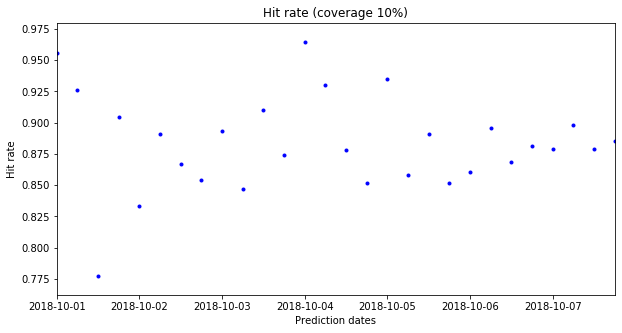

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['hit_rate_default_coverage_10'].values, marker=".",color='blue')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('Hit rate (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('Hit rate')
plt.show()

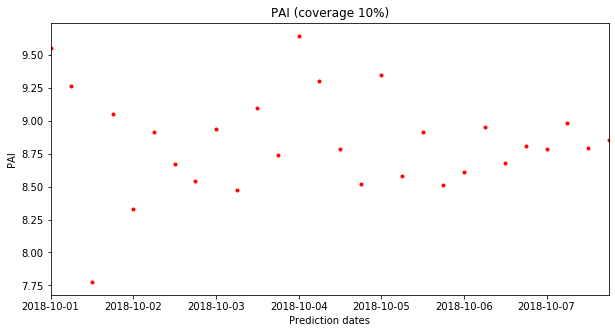

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['PAI_default_coverage_10'].values, marker=".",color='red')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('PAI (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('PAI')
plt.show()

### NUSE ground truth

In [41]:
df_result = result.copy()

In [42]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_nuse'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['average_prediction'],row['eval_pts_nuse'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [43]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [44]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [45]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

siedco_entropy                  10.647107
rnmc_entropy                    11.649933
nuse_entropy                    12.495310
multimodal_average_entropy      12.535316
multimodal_max_entropy          11.649933
coverage_TP                      0.365678
hit_rate_TP                      0.101395
PAI_TP                          31.709312
hit_rate_default_coverage_2      0.271355
PAI_default_coverage_2          13.567731
hit_rate_default_coverage_4      0.407541
PAI_default_coverage_4          10.188530
hit_rate_default_coverage_6      0.597442
PAI_default_coverage_6           9.957364
hit_rate_default_coverage_8      0.719034
PAI_default_coverage_8           8.987928
hit_rate_default_coverage_10     0.791507
PAI_default_coverage_10          7.915074
hit_rate_default_coverage_12     0.878910
PAI_default_coverage_12          7.324253
hit_rate_default_coverage_14     0.934152
PAI_default_coverage_14          6.672511
hit_rate_default_coverage_16     0.948344
PAI_default_coverage_16          5

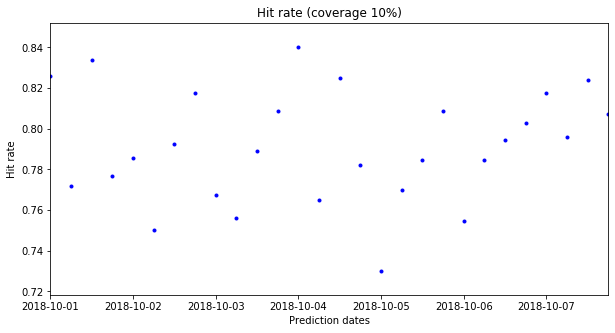

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['hit_rate_default_coverage_10'].values, marker=".",color='blue')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('Hit rate (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('Hit rate')
plt.show()

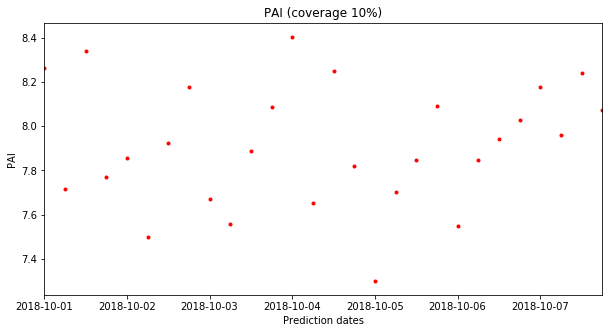

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_result['initial-date'].values, df_result['PAI_default_coverage_10'].values, marker=".",color='red')
ax.set_xlim(df_result['initial-date'].values[0], df_result['initial-date'].values[-1])
ax.set_title('PAI (coverage 10%)')
plt.xlabel('Prediction dates')
plt.ylabel('PAI')
plt.show()